# Python: PLM and IRM for Multiple Treatments

In this example, we show the behavior of the PLM and IRM estimators when the treatment effect is heterogeneous across different treatments. We show that since the PLM estimates a convex-weighted average of treatment effects, it is not able to recover the true treatment effects when they are heterogeneous. On the other hand, the IRM estimator is able to recover the true treatment effects when they are heterogeneous. This is shown to matter substantially when ranking treatments by their estimated treatment effects.


We assume basic knowledge of the potential outcomes framework and the assumptions of the PLM and IRM estimators. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from doubleml import DoubleMLData, DoubleMLPLR, DoubleMLIRM
from xgboost import XGBRegressor, XGBClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Ranking Treatment Effects under Treatment Propensity and Treatment Effect Heterogeneity

We consider a setting with two treatments $D_1$ and $D_2$, a single binary covariate $X$ (with $p=0.5$), and a continuous outcome $Y$. The propensity scores for the two treatments are given by:

| X \ D | $D_1$ = 1 | $D_2$ = 1 |
|-------|--------|--------|
| X = 0 |  0.01  |  0.5   |
| X = 1 |  0.5   |  0.01  |

And the underlying heterogeneous treatment effects are given by:

| X \ $\tau$ | $\tau_1$ | $\tau_2$  |
|-------|----|----|
| X = 0 | -3 | -2 |
| X = 1 |  3 |  3 |
| ATE   |  0 | 0.5|

The researcher seeks to rank the two treatments based on their average treatment effects. We compare the behavior of the PLM and IRM estimators in this setting.

We implement the DGP below.

In [2]:

def dgp(
    n = 100_000,
    treat1_params = {
        "p_x0": 0.01, "p_x1": 0.50, "τ_x0": -3, "τ_x1": 3,
    },
    treat2_params = {
        "p_x0": 0.5, "p_x1": 0.01, "τ_x0": -2, "τ_x1": 3,
    },
    ):
    # utility functions to transform between the probability scale and the logit scale
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    inv_sigmoid = lambda p: np.log(p / (1 - p))

    df = pd.DataFrame()
    # noise terms
    eta1 = np.random.normal(0, 0.1, size=n)
    eta2 = np.random.normal(0, 0.1, size=n)
    eps = np.random.normal(0, 1, size=n)
    # binary covariate
    df["x"] = np.random.randint(2, size=n)  # half and half
    df[["x0", "x1"]] = pd.get_dummies(df.x)
    # treatment 1 propensity score
    pscore1 = df.x0 * (inv_sigmoid(treat1_params["p_x0"]) + eta1) + df.x1 * (
        inv_sigmoid(treat1_params["p_x1"]) + eta2
    )
    # treatment 2 propensity score
    pscore2= df.x0 * (inv_sigmoid(treat2_params["p_x0"]) + eta2) + df.x1 * (
        inv_sigmoid(treat2_params["p_x1"]) + eta2
    )
    df['d1'] = np.random.binomial(1, sigmoid(pscore1))
    df['d2'] = np.random.binomial(1, sigmoid(pscore2))
    # outcome 1
    df["y"] = (
        0
        + 1 * df.x0 # arbitrary covariate coefs
        - 2 * df.x1
        + df.x0 * df.d1 * (treat1_params["τ_x0"])
        + df.x1 * df.d1 * (treat1_params["τ_x1"])
        + df.x0 * df.d2 * (treat2_params["τ_x0"])
        + df.x1 * df.d2 * (treat2_params["τ_x1"])
        + eps
    )
    return df.drop(["x0", "x1"], axis=1)
df = dgp()
df.head()

,x,d1,d2,y
0,1,1,0,0.238318
1,1,0,0,0.968977
2,0,0,1,-0.069466
3,0,0,1,-0.648016
4,0,0,0,1.588667


In [3]:
print(pd.crosstab(df.x, df.d1, normalize='index'))
print(pd.crosstab(df.x, df.d2, normalize='index'))

d1         0         1
x                     
0   0.990137  0.009863
1   0.501989  0.498011
d2         0         1
x                     
0   0.500190  0.499810
1   0.989863  0.010137


### The Partially Linear Model performs overlap weighting

The partially linear model inherits the properties of linear regression under treatment effect heterogeneity (Angrist (1998), Angrist and Krueger(1999), Aronow and Samii (2016)). The probability limit of the treatment coefficient in the partially linear model $Y_i = \tau D_i + g(X_i) + \epsilon_i$ is given by:

$$
p\!\!-\!\!\lim \hat{\tau} = \mathbb{E} [\gamma(X) \tau(X)]
$$

where 

$$
\gamma(X) = \frac{\mathbb{V}(D \mid X)}{\mathbb{E} [\mathbb{V}(D \mid X)]}
$$

This simplifies to 

$$
\gamma(X) = \frac{p(X)(1-p(X))}{\mathbb{E}[p(X)(1-p(X))]}
$$

when $D$ is binary.

We have deliberately generated a dataset with varying propensity scores across treatments and covariates. Since we have a single binary covariate, we can analytically estimate the plim of the above estimator. The regression coefficients are equal to:

$$
\begin{align*}
\tilde{\tau}_1 & = \frac{-3 \cdot 0.01 \cdot 0.99 + 3 \cdot 0.5 \cdot 0.5}{
  0.01 \cdot 0.99 + 0.5 \cdot 0.5
} = 2.7714 \\
\tilde{\tau}_2 & = \frac{-2 \cdot 0.5 \cdot 0.5 + 3 \cdot 0.01 \cdot 0.99}{0.01 \cdot 0.99 + 0.5 \cdot 0.5} = -1.8095
\end{align*}
$$

So, we see that the PLM gets the ranking wrong; even though the treatment effect of $D_1$ (0) is lower than that of $D_2$ (0.5), the PLM estimates the treatment effect of $D_1$ to be higher than that of $D_2$ because it upweights the stratum with large positive effects when estimating the effect for $D_1$ and vice versa for $D_2$.

We verify this numerically with the `DoubleML`.

In [4]:
df = dgp()
dml_data = DoubleMLData(df, 'y', ['d1', 'd2'], 'x')
plr_obj = DoubleMLPLR(dml_data,
                      ml_l =  XGBRegressor(),
                      ml_m = XGBClassifier(),
                      n_folds=5)
plr_obj.fit()
plr_est = plr_obj.summary
print(plr_est)

        coef   std err           t  P>|t|     2.5 %    97.5 %
d1  2.768634  0.013156  210.439453    0.0  2.742848  2.794421
d2 -1.794049  0.012280 -146.098145    0.0 -1.818117 -1.769981


###  The Augmented Inverse Propensity Weighting Model estimates the ATE under arbitrary effect and propensity score heterogeneity

The AIPW estimator is given by:

$$
\tau_{\text{AIPW}} = \frac{1}{n} \sum_i \left( \left[ \hat{g}(1, X_i) - \hat{g}(0, X_i) \right] + 
\frac{D_i(Y_i - \hat{g}(1, X_i))}{\hat{m}(X_i)} - \frac{(1-D_i)(Y_i - \hat{g}(0, X_i))}{1 - \hat{m}(X_i)}
\right)
$$

and estimates the ATE consistently under arbitrary treatment effect and propensity score heterogeneity, and therefore ranks the two treatments correctly (i.e. $D_2$ has a higher treatment effect than $D_1$).


In [5]:
df = dgp()
aipw_obj_1 = DoubleMLIRM(DoubleMLData(df, 'y', ['d1'], 'x'),
                      ml_g = XGBRegressor(),
                      ml_m = XGBClassifier(),
                      n_folds=5)
aipw_obj_1.fit()
aipw_obj_2 = DoubleMLIRM(DoubleMLData(df, 'y', ['d2'], 'x'),
                      ml_g = XGBRegressor(),
                      ml_m = XGBClassifier(),
                      n_folds=5)
aipw_obj_2.fit()
aipw_est_1, aipw_est_2 = aipw_obj_1.summary, aipw_obj_2.summary
print(aipw_est_1)
print(aipw_est_2)

        coef   std err         t     P>|t|     2.5 %    97.5 %
d1  0.030327  0.032595  0.930416  0.352156 -0.033558  0.094211
        coef   std err          t         P>|t|     2.5 %    97.5 %
d2  0.530923  0.041266  12.866012  6.992045e-38  0.450044  0.611802


## Summary Figure

We summarize the true treatment effects, the PLM estimates, and the IRM estimates in a figure.

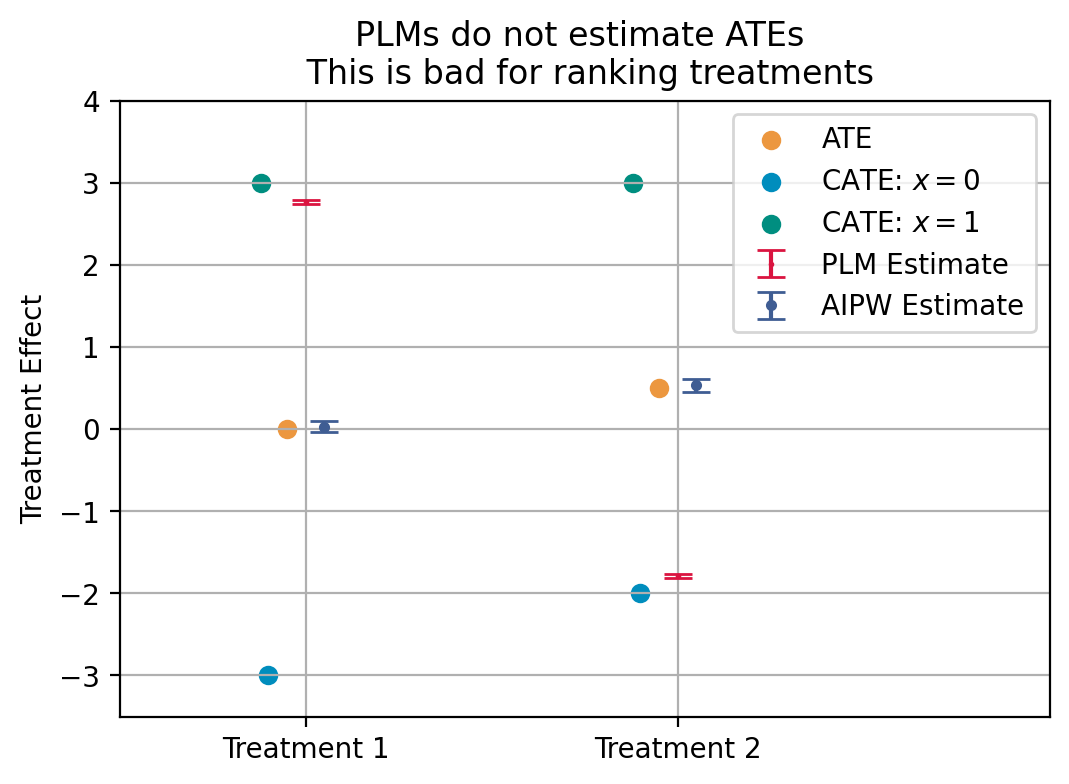

In [6]:

colors = ['#da1440', '#e45228', '#ec973f', '#a4a147', '#008e80', '#008dbd',
          '#f6ebce', '#838235', '#3f5d93', '#50768b', '#133f5a', '#afd9e4']

# Plot the data
x = np.array([1, 2])
y = [(-3+3)/2, (-2+3)/2]
fig, ax = plt.subplots(dpi = 100, figsize = (6, 4))
# plm
plt.errorbar(x,
    plr_est.coef,
    yerr=1.96 * plr_est['std err'], markersize = 1,
    fmt='o', color=colors[0], ecolor=colors[0], capsize=5, label = 'PLM Estimate')
plt.errorbar(x+.05,
    np.array([aipw_est_1.coef, aipw_est_2.coef]).flatten(),
    yerr = 1.96 * np.array([aipw_est_1.iloc[:,1].values[0],
                            aipw_est_2.iloc[:,1].values[0]]),
    markersize = 3,
    fmt='o', color=colors[8], ecolor=colors[8], capsize=5, label = 'AIPW Estimate'
    )
# true values
plt.scatter(x-.05, y,       color = colors[2], label = 'ATE')
plt.scatter(x-.1, [-3, -2], color = colors[5], label=r"CATE: $x=0$")
plt.scatter(x-.12, [3, 3],  color = colors[4], label=r"CATE: $x=1$")
plt.legend(loc = 0)
plt.title("PLMs do not estimate ATEs \n This is bad for ranking treatments")
plt.axis((.5, 3, -3.5, 4))
ax.set_xticks([])
string_labels = ['Treatment 1', 'Treatment 2']
ax.set_xticks(x)
ax.set_xticklabels(string_labels)
ax.grid(True)
ax.set_ylabel("Treatment Effect")
plt.show()

## Additional Results: CATE estimates

As an additional comparison, we can add the CATE estimates based on the previous PLR and IRM examples.

In [7]:
# pandas data frame with one-hot encoded values for x
groups = pd.get_dummies(df.x)

In [8]:
# Repeat estimation for each treatment var separately
# d1
dml_data = DoubleMLData(df, 'y', 'd1', ['d2', 'x'])
plr_obj_1 = DoubleMLPLR(dml_data,
                      ml_l =  XGBRegressor(),
                      ml_m = XGBClassifier(),
                      n_folds=5)
plr_obj_1.fit()
plr_est1 = plr_obj_1.summary
plr_obj_1.gate(groups=groups).summary.round(3)


,coef,std err,t,P>|t|,[0.025,0.975]
0,-2.999,0.042,-71.117,0.0,-3.081,-2.916
1,3.006,0.009,337.247,0.0,2.989,3.024


In [9]:
# d2
dml_data = DoubleMLData(df, 'y', 'd2', ['d1', 'x'])
plr_obj_2 = DoubleMLPLR(dml_data,
                      ml_l =  XGBRegressor(),
                      ml_m = XGBClassifier(),
                      n_folds=5)
plr_obj_2.fit()
plr_est2 = plr_obj_2.summary
plr_obj_2.gate(groups=groups).summary.round(3)

,coef,std err,t,P>|t|,[0.025,0.975]
0,-2.006,0.009,-224.012,0.0,-2.023,-1.988
1,3.065,0.046,67.281,0.0,2.976,3.154


In [10]:
# IRM models
# d1
aipw_obj_1.gate(groups=groups).summary.round(3)

,coef,std err,t,P>|t|,[0.025,0.975]
0,-2.964,0.062,-47.895,0.0,-3.086,-2.843
1,3.005,0.009,322.078,0.0,2.987,3.024


In [11]:
# IRM models
# d2
aipw_obj_2.gate(groups=groups).summary.round(3)

,coef,std err,t,P>|t|,[0.025,0.975]
0,-2.003,0.009,-214.098,0.0,-2.022,-1.985
1,3.048,0.080,38.027,0.0,2.891,3.206


## References

- Lal, A., Chou, W., & Schaefer, J. (2024). Using Double Machine Learning to Rank Treatments, Working Paper. Poster available at [https://apoorvalal.github.io/files/slides/acic_2024_poster.pdf](https://apoorvalal.github.io/files/slides/acic_2024_poster.pdf). Thread available at [https://x.com/Apoorva__Lal/status/1798913180930109556](https://x.com/Apoorva__Lal/status/1798913180930109556).
- Angrist, J. D. (1998). Estimating the labor market impact of voluntary military service using social security data on military applicants. Econometrica, 66(2), 249-288.
- Angrist, J. D., & Krueger, A. B. (1999). Empirical strategies in labor economics. Handbook of labor economics, 3, 1277-1366.
- Aronow, P. M., & Samii, C. (2016). Does regression produce representative estimates of causal effects?. American Journal of Political Science, 60(1), 250-267.
